# Mask Data Analysis

This notebook loads and analyzes the freeze masks generated from different cache mixing strategies.

Each mask represents the frequency that each cache position was selected to use the slow cache across 1000 samples.

## Import Required Libraries

In [6]:
import numpy as np
import torch
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Define File Paths and Parameters

In [7]:
# Directory containing the mask files
mask_dir = Path("./masks")

# Top-k percentage used in experiments
top_k_percent = 10

# Strategy names
strategies = {
    'layerdist': 'Layer-wise Distance',
    'layervalue': 'Layer-wise Value',
    'layerangle': 'Layer-wise Angle',
    'alldist': 'Global Distance',
    'allvalue': 'Global Value',
    'allangle': 'Global Angle'
}

# File naming pattern
k_str = str(int(top_k_percent)) if top_k_percent == int(top_k_percent) else str(top_k_percent).replace('.', 'p')

print(f"Mask directory: {mask_dir}")
print(f"Top-k percent: {top_k_percent}%")
print(f"Strategies to load: {list(strategies.keys())}")

Mask directory: masks
Top-k percent: 10%
Strategies to load: ['layerdist', 'layervalue', 'layerangle', 'alldist', 'allvalue', 'allangle']


## Load Mask Files

In [8]:
# Dictionary to store all loaded masks
masks = {}

# Load each mask file
for strategy_name in strategies.keys():
    filename = f"mask_{strategy_name}{k_str}_useful.npy"
    filepath = mask_dir / filename
    
    if filepath.exists():
        # Load numpy array
        mask_np = np.load(filepath)
        
        # Convert to PyTorch tensor
        mask_tensor = torch.from_numpy(mask_np)
        
        # Store in dictionary
        masks[strategy_name] = mask_tensor
        
        print(f"✓ Loaded {strategy_name:12s}: {filepath.name:40s} -> shape {tuple(mask_tensor.shape)}")
    else:
        print(f"✗ Missing {strategy_name:12s}: {filename}")

print(f"\nTotal masks loaded: {len(masks)}/{len(strategies)}")

✓ Loaded layerdist   : mask_layerdist10_useful.npy              -> shape (64, 1, 5120, 16)
✓ Loaded layervalue  : mask_layervalue10_useful.npy             -> shape (64, 1, 5120, 16)
✓ Loaded layerangle  : mask_layerangle10_useful.npy             -> shape (64, 1, 5120, 16)
✓ Loaded alldist     : mask_alldist10_useful.npy                -> shape (64, 1, 5120, 16)
✓ Loaded allvalue    : mask_allvalue10_useful.npy               -> shape (64, 1, 5120, 16)
✓ Loaded allangle    : mask_allangle10_useful.npy               -> shape (64, 1, 5120, 16)

Total masks loaded: 6/6


## Verify Loaded Data

Display basic statistics for each loaded mask to verify successful loading.

In [9]:
print("=" * 80)
print("MASK STATISTICS")
print("=" * 80)

for strategy_name, mask_tensor in masks.items():
    print(f"\n{strategies[strategy_name]} ({strategy_name}):")
    print(f"  Shape:        {tuple(mask_tensor.shape)}")
    print(f"  Dtype:        {mask_tensor.dtype}")
    print(f"  Min value:    {mask_tensor.min().item()}")
    print(f"  Max value:    {mask_tensor.max().item()}")
    print(f"  Mean value:   {mask_tensor.float().mean().item():.2f}")
    print(f"  Median value: {mask_tensor.float().median().item():.2f}")
    print(f"  Total elements: {mask_tensor.numel():,}")
    print(f"  Non-zero elements: {(mask_tensor > 0).sum().item():,}")

MASK STATISTICS

Layer-wise Distance (layerdist):
  Shape:        (64, 1, 5120, 16)
  Dtype:        torch.int32
  Min value:    0
  Max value:    1000
  Mean value:   100.00
  Median value: 30.00
  Total elements: 5,242,880
  Non-zero elements: 4,142,112

Layer-wise Value (layervalue):
  Shape:        (64, 1, 5120, 16)
  Dtype:        torch.int32
  Min value:    0
  Max value:    1000
  Mean value:   100.00
  Median value: 10.00
  Total elements: 5,242,880
  Non-zero elements: 3,675,264

Layer-wise Angle (layerangle):
  Shape:        (64, 1, 5120, 16)
  Dtype:        torch.int32
  Min value:    0
  Max value:    1000
  Mean value:   100.00
  Median value: 66.00
  Total elements: 5,242,880
  Non-zero elements: 4,652,560

Global Distance (alldist):
  Shape:        (64, 1, 5120, 16)
  Dtype:        torch.int32
  Min value:    0
  Max value:    1000
  Mean value:   100.00
  Median value: 1.00
  Total elements: 5,242,880
  Non-zero elements: 2,666,848

Global Value (allvalue):
  Shape:     

## Summary

All masks have been loaded into the `masks` dictionary. The keys are:
- `'layerdist'` - Layer-wise distance strategy
- `'layervalue'` - Layer-wise value strategy
- `'layerangle'` - Layer-wise angle strategy
- `'alldist'` - Global distance strategy
- `'allvalue'` - Global value strategy
- `'allangle'` - Global angle strategy

Each mask is a PyTorch tensor with shape `[num_layers, batch, d_inner, d_state]` containing integer counts (0-1000) representing how many times each position was selected to use the slow cache.

Ready for further analysis!

## Visualize Mask Frequency Distribution

Plot histogram showing the frequency distribution of selection counts for each strategy.

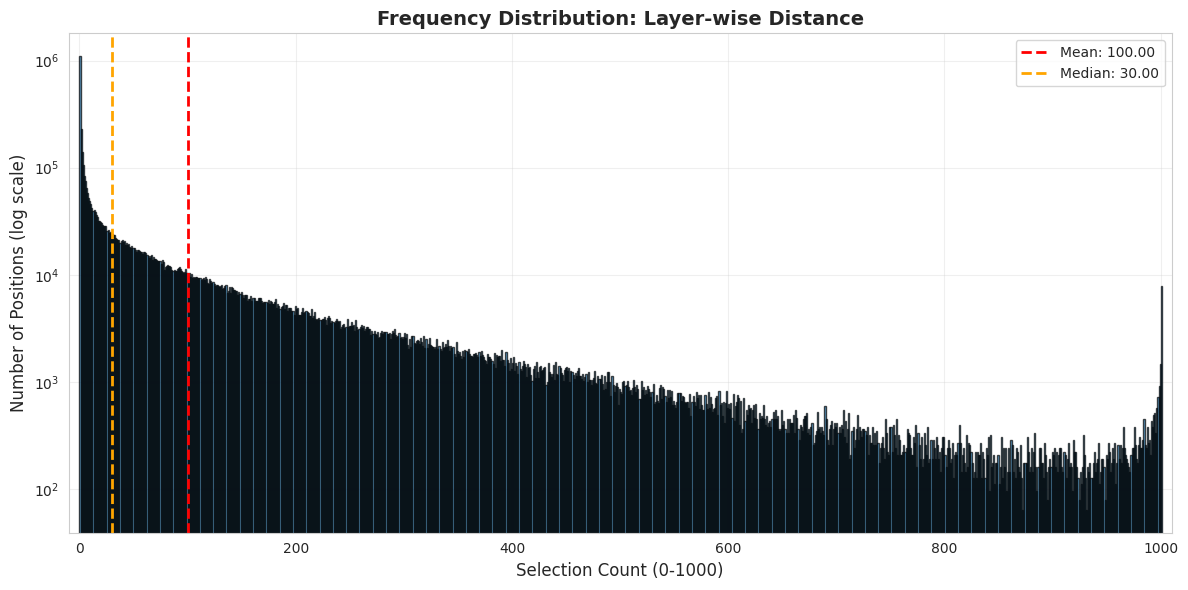

Total positions: 5,242,880
Mean selection count: 100.00
Median selection count: 30.00
Max count in histogram: 1,100,768 positions


In [11]:
# Example: Plot histogram for layerdist strategy
strategy_name = 'layerdist'
mask = masks[strategy_name]

# Flatten the mask to get all values
values = mask.flatten().numpy()

# Create histogram
fig, ax = plt.subplots(figsize=(12, 6))
counts, bins, patches = ax.hist(values, bins=np.arange(0, 1002, 1), edgecolor='black', alpha=0.7)

ax.set_xlabel('Selection Count (0-1000)', fontsize=12)
ax.set_ylabel('Number of Positions (log scale)', fontsize=12)
ax.set_title(f'Frequency Distribution: {strategies[strategy_name]}', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xlim(-10, 1010)

# Set y-axis to log scale
ax.set_yscale('log')

# Add statistics text
mean_val = values.mean()
median_val = np.median(values)
ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
ax.axvline(median_val, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

print(f"Total positions: {len(values):,}")
print(f"Mean selection count: {mean_val:.2f}")
print(f"Median selection count: {median_val:.2f}")
print(f"Max count in histogram: {counts.max():,.0f} positions")

## Compare All Strategies

Plot all 6 strategies in a single figure for comparison.

Layer-wise Value          - Mean: 100.00, Median:  10.00, Max count: 1,567,616
Global Value              - Mean: 100.00, Median:   0.00, Max count: 2,648,123
Layer-wise Distance       - Mean: 100.00, Median:  30.00, Max count: 1,100,768
Global Distance           - Mean: 100.00, Median:   1.00, Max count: 2,576,032
Layer-wise Angle          - Mean: 100.00, Median:  66.00, Max count: 590,320
Global Angle              - Mean: 100.00, Median:  48.00, Max count: 788,560


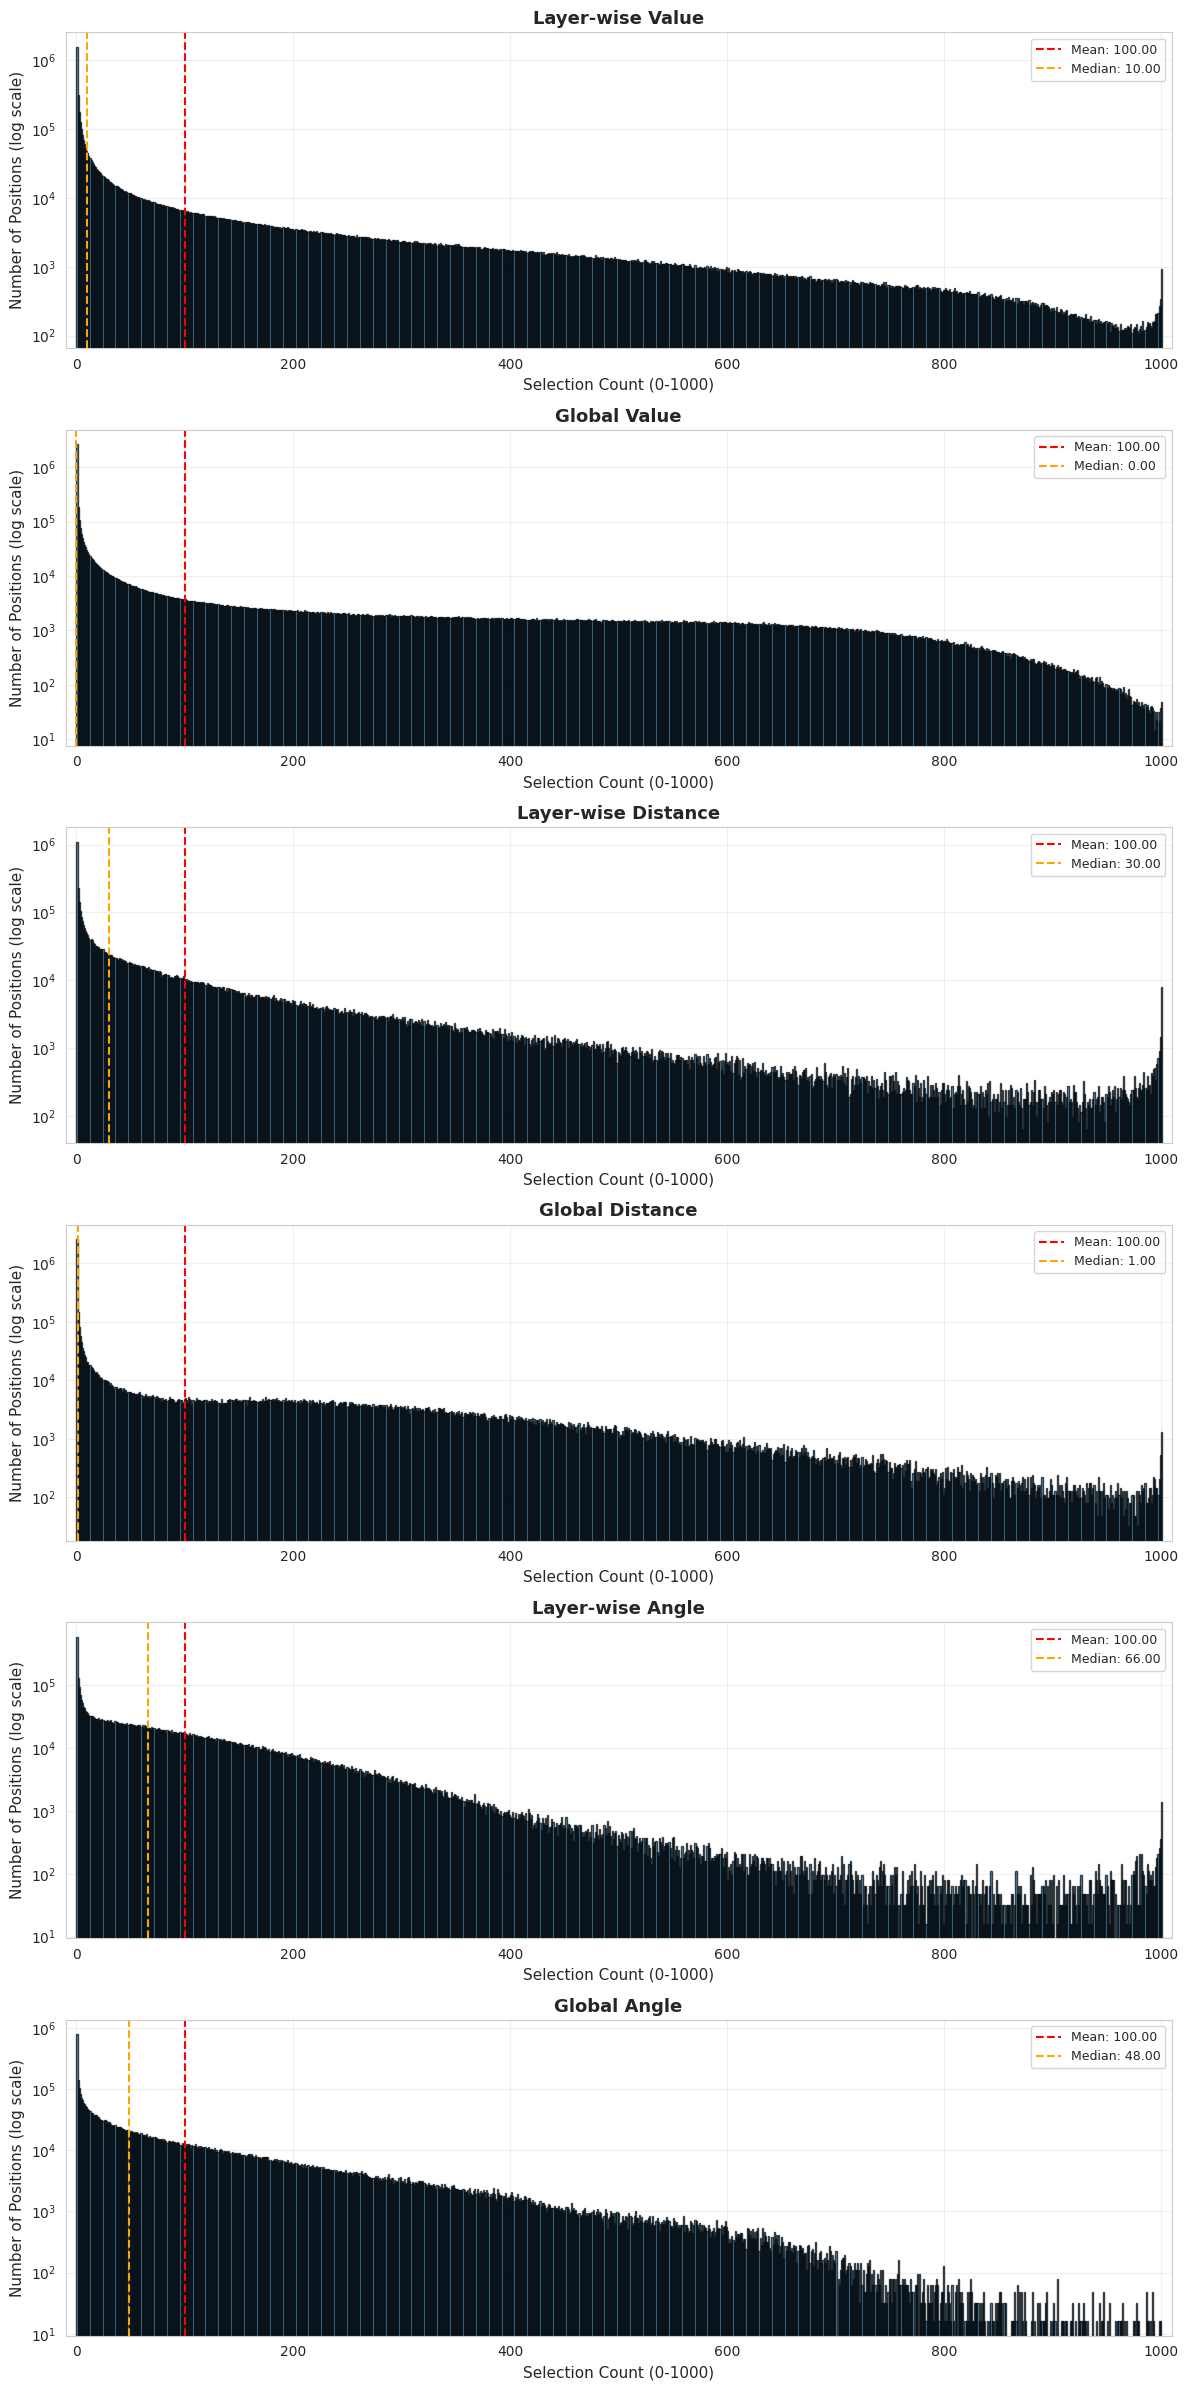

In [13]:
# Create a figure with 6 subplots (one column, 6 rows)
fig, axes = plt.subplots(6, 1, figsize=(12, 24))

# List of strategy names in the order we want to plot
strategy_order = ['layervalue', 'allvalue', 'layerdist', 'alldist', 'layerangle', 'allangle']

for idx, strategy_name in enumerate(strategy_order):
    ax = axes[idx]
    mask = masks[strategy_name]
    
    # Flatten the mask to get all values
    values = mask.flatten().numpy()
    
    # Create histogram
    counts, bins, patches = ax.hist(values, bins=np.arange(0, 1002, 1), edgecolor='black', alpha=0.7)
    
    ax.set_xlabel('Selection Count (0-1000)', fontsize=11)
    ax.set_ylabel('Number of Positions (log scale)', fontsize=11)
    ax.set_title(f'{strategies[strategy_name]}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-10, 1010)
    
    # Set y-axis to log scale
    ax.set_yscale('log')
    
    # Add statistics text
    mean_val = values.mean()
    median_val = np.median(values)
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='orange', linestyle='--', linewidth=1.5, label=f'Median: {median_val:.2f}')
    ax.legend(fontsize=9, loc='upper right')
    
    # Print statistics for each strategy
    print(f"{strategies[strategy_name]:25s} - Mean: {mean_val:6.2f}, Median: {median_val:6.2f}, Max count: {counts.max():,.0f}")

plt.tight_layout()
plt.show()